In [10]:
import numpy as np
import pandas as pd
import gym
from gym import Env
from gym.spaces import Box, Discrete, MultiDiscrete
import os
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Convolution2D
from tensorflow.keras.optimizers import Adam
import random
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
import scipy.stats as st
import mplfinance as mpf
from scipy.optimize import minimize

In [17]:
def generate_ohlc_data(means, correlation_matrix, num_days=5040, num_timesteps=24):
    column_names = [f'Stock_{i+1}_{col}' for i in range(len(means)) for col in ['Open', 'High', 'Low', 'Close']]
    ohlc_data = []
    
    # Fill the first row with ones
    ohlc_data.append([1] * len(column_names))

    for day in range(num_days):
        # Generate data for one day
        a = st.multivariate_normal.rvs(means, correlation_matrix, size=(1, num_timesteps))
        a = np.exp(a)
        lity = []
        #print(a)
        
        for timestep in range(len(a[0])):
            close_prev = ohlc_data[-1][3 + timestep * 4]
            #print(np.cumsum(a[:,timestep]) , close_prev)
            
            lity.append(close_prev)
            lity.append(close_prev * max(np.cumprod(a[:, timestep])))  # High
            lity.append(close_prev * min(np.cumprod(a[:, timestep])))  # Low
            lity.append(close_prev * np.cumprod(a[:, timestep])[-1])   # Close
        #print(lity)
        
        ohlc_data.append((lity))
    
    return pd.DataFrame(ohlc_data, columns=column_names)
#means = [0.00003, 0.00002, 0.000035, 0.00001, 0.000025]
means = [0.00003, 0.00002, 0.000035]
correlation_matrix = np.array([[0.000034, 0.0000075, -0.00001],
                               [0.0000075, 0.000012, -0.000008],
                               [-0.00001, -0.000008, 0.000045]
])
#correlation_matrix = np.array([[0.000034, 0.0000075, -0.00001, 0, 0.000006],
#                               [0.0000075, 0.000012, -0.000008, 0.000005, -0.000003],
#                               [-0.00001, -0.000008, 0.000045, 0.000003, 0.000002],
#                               [0, 0.000005, 0.000003, 0.000008, 0.000004],
#                               [0.000006, -0.000003, 0.000002, 0.000004, 0.0001]])

OHLC = generate_ohlc_data(means=means, correlation_matrix=correlation_matrix)
OHLC = OHLC.drop(OHLC.index[0]).reset_index(drop=True)

OHLC.head()

,Stock_1_Open,Stock_1_High,Stock_1_Low,Stock_1_Close,Stock_2_Open,Stock_2_High,Stock_2_Low,Stock_2_Close,Stock_3_Open,Stock_3_High,Stock_3_Low,Stock_3_Close
0,1.000000,1.018485,0.990876,1.018485,1.000000,1.026700,0.998048,1.024998,1.000000,1.011482,0.987580,0.996928
1,1.018485,1.023493,0.984035,1.014512,1.024998,1.028573,0.998617,0.999677,0.996928,1.004609,0.983219,0.990221
2,1.014512,1.017215,0.983373,0.983373,0.999677,1.002935,0.969234,0.977267,0.990221,1.011462,0.938024,0.941876
3,0.983373,1.001211,0.959484,0.964638,0.977267,0.987813,0.971354,0.971354,0.941876,0.945034,0.923043,0.945034
4,0.964638,0.959020,0.914044,0.914044,0.971354,0.979582,0.966978,0.968349,0.945034,0.992725,0.943783,0.992725


c:\Users\20213931\AppData\Local\Programs\Python\Python311\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


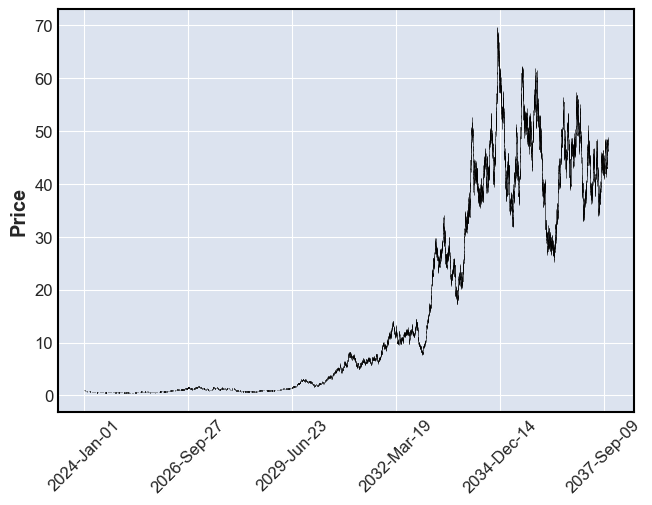

c:\Users\20213931\AppData\Local\Programs\Python\Python311\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


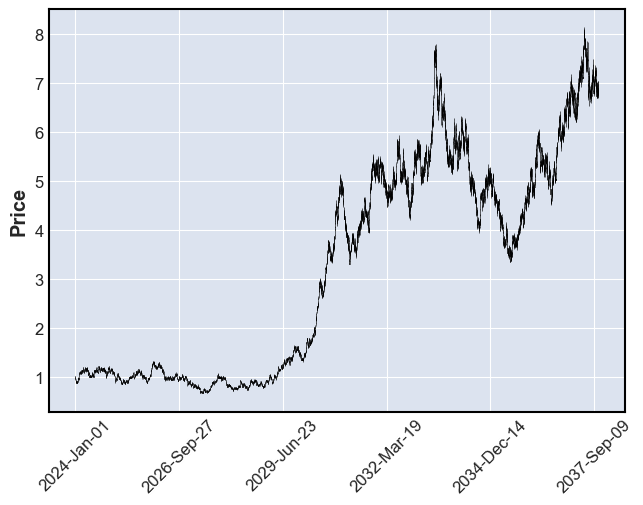

c:\Users\20213931\AppData\Local\Programs\Python\Python311\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


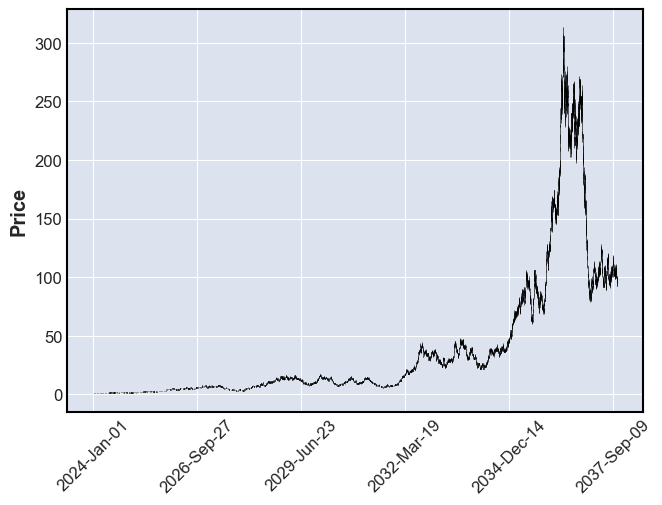

ValueError: Column "Open" NOT FOUND in Input DataFrame!
            CHECK that your column names are correct AND/OR
            CHECK for leading or trailing blanks in your column names.

In [18]:

# Convert OHLC data to the format required by mplfinance
mpf_data_1 = OHLC.rename(columns={'Stock_1_Open': 'Open', 'Stock_1_High': 'High', 'Stock_1_Low': 'Low', 'Stock_1_Close': 'Close'})
mpf_data_1.index = pd.date_range(start='2024-01-01', periods=len(mpf_data_1))  # Assuming a start date of '2024-01-01'

mpf_data_2 = OHLC.rename(columns={'Stock_2_Open': 'Open', 'Stock_2_High': 'High', 'Stock_2_Low': 'Low', 'Stock_2_Close': 'Close'})
mpf_data_2.index = pd.date_range(start='2024-01-01', periods=len(mpf_data_2))  # Assuming a start date of '2024-01-01'

mpf_data_3 = OHLC.rename(columns={'Stock_3_Open': 'Open', 'Stock_3_High': 'High', 'Stock_3_Low': 'Low', 'Stock_3_Close': 'Close'})
mpf_data_3.index = pd.date_range(start='2024-01-01', periods=len(mpf_data_2))  # Assuming a start date of '2024-01-01'

mpf_data_4 = OHLC.rename(columns={'Stock_4_Open': 'Open', 'Stock_4_High': 'High', 'Stock_4_Low': 'Low', 'Stock_4_Close': 'Close'})
mpf_data_4.index = pd.date_range(start='2024-01-01', periods=len(mpf_data_2))  # Assuming a start date of '2024-01-01'

mpf_data_5 = OHLC.rename(columns={'Stock_5_Open': 'Open', 'Stock_5_High': 'High', 'Stock_5_Low': 'Low', 'Stock_5_Close': 'Close'})
mpf_data_5.index = pd.date_range(start='2024-01-01', periods=len(mpf_data_2))  # Assuming a start date of '2024-01-01'


# Plot candlestick chart for the first stock
mpf.plot(mpf_data_1, type='candle')

# Plot candlestick chart for the second stock
mpf.plot(mpf_data_2, type='candle')

# Plot candlestick chart for the second stock
mpf.plot(mpf_data_3, type='candle')

# Plot candlestick chart for the second stock
mpf.plot(mpf_data_4, type='candle')

# Plot candlestick chart for the second stock
mpf.plot(mpf_data_5, type='candle')



In [ ]:
OHLC.head()

,Stock_1_Open,Stock_1_High,Stock_1_Low,Stock_1_Close,Stock_2_Open,Stock_2_High,Stock_2_Low,Stock_2_Close,Stock_3_Open,Stock_3_High,Stock_3_Low,Stock_3_Close,Stock_4_Open,Stock_4_High,Stock_4_Low,Stock_4_Close,Stock_5_Open,Stock_5_High,Stock_5_Low,Stock_5_Close
0,1.000000,0.992162,0.963555,0.973981,1.000000,0.993317,0.979867,0.989777,1.000000,1.038044,1.005038,1.016787,1.000000,1.016947,1.000104,1.016947,1.000000,1.005070,0.944732,1.005070
1,0.973981,1.001758,0.962497,1.001758,0.989777,1.017615,0.984421,1.017615,1.016787,1.031516,0.980201,0.980201,1.016947,1.032432,1.007952,1.029800,1.005070,1.032166,0.919722,0.919722
2,1.001758,1.017126,0.941049,0.957751,1.017615,1.023245,0.994780,1.009608,0.980201,0.995395,0.968753,0.993812,1.029800,1.039222,1.021231,1.037299,0.919722,0.962608,0.905027,0.957061
3,0.957751,0.973398,0.943814,0.948715,1.009608,1.029902,1.006040,1.011000,0.993812,1.004553,0.972102,1.004493,1.037299,1.049547,1.036864,1.049547,0.957061,0.999477,0.923077,0.956285
4,0.948715,0.957959,0.931591,0.946294,1.011000,1.027671,1.006259,1.027671,1.004493,1.013878,0.975266,0.981114,1.049547,1.058422,1.039334,1.051908,0.956285,0.968415,0.938633,0.938633


In [19]:
def StandardizeData(data, n):
    if isinstance(data, pd.DataFrame):
        df = data.copy()  # Make a copy to avoid modifying the original DataFrame
    elif isinstance(data, list):
        df = pd.DataFrame(data)  # Convert list to DataFrame
    else:
        raise ValueError("Input data must be a DataFrame or a list.")
    
    Standardized = pd.DataFrame()
    for col in df.columns:
        ST = pd.DataFrame()
        for i in range(n+1):
            stock_num = int(col.split('_')[1])  # Extract the stock number from the column name
            close_col = f'Stock_{stock_num}_Close'  # Get the corresponding 'Close' column
            ST[f'{col}_{i}'] = df[col].shift(-i) / df[close_col].shift(-n)  # Divide by the corresponding 'Close' column
        Standardized = pd.concat([Standardized, ST], axis=1)
    
    # Drop rows with NaN values
    


    Ratio = pd.DataFrame()
    close_columns = [col for col in df.columns if 'Close' in col]
    for col in close_columns:
        
        Ratio[col] = df[col].shift(-n-1) /df[col].shift(-n) -1
        Ratio.dropna()


    return Standardized[:-n-1], Ratio[:-n-1]





InputStates, RewardVector = StandardizeData(OHLC, 4)
print(RewardVector.iloc[:2529].cov() , RewardVector.iloc[:2529].mean())

               Stock_1_Close  Stock_2_Close  Stock_3_Close
Stock_1_Close       0.000831       0.000186      -0.000233
Stock_2_Close       0.000186       0.000290      -0.000198
Stock_3_Close      -0.000233      -0.000198       0.001092 Stock_1_Close    0.001191
Stock_2_Close    0.000765
Stock_3_Close    0.001407
dtype: float64


In [24]:
InputStates*=10000

In [25]:
def tangency_weights(covariance_matrix, mean_vector):
    n = len(mean_vector)
    
    # Objective function to maximize (Sharpe ratio)
    def objective_function(weights):
        portfolio_return = np.dot(weights, mean_vector)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
        return -portfolio_return / portfolio_std
    
    # Constraint: sum of weights equals 1
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    
    # Bounds for each weight (0 <= weight <= 1)
    bounds = tuple((0, 1) for _ in range(n))
    
    # Initial guess for weights
    initial_guess = np.ones(n) / n
    
    # Optimization
    result = minimize(objective_function, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    
    # Extracting optimal weights
    optimal_weights = result.x
    
    # Calculate the mean and standard deviation of the tangency portfolio
    tangency_return = np.dot(optimal_weights, mean_vector)
    tangency_std = np.sqrt(np.dot(optimal_weights.T, np.dot(covariance_matrix, optimal_weights)))
    
    return {
        'weights': optimal_weights,
        'mean': tangency_return,
        'std': tangency_std,
        'maximized_value': -result.fun  # Negative because we minimized the negative of Sharpe ratio
    }

# Example usage:
result = tangency_weights(RewardVector.iloc[:2529].cov(), RewardVector.iloc[:2529].mean())
print("Optimal Weights:", result['weights'])
print("Tangency Portfolio Mean:", result['mean']*100)
print("Tangency Portfolio Standard Deviation:", result['std'])
print("Maximized Value:", result['maximized_value'])


Optimal Weights: [0.19350188 0.48580979 0.32068832]
Tangency Portfolio Mean: 0.10530751594743429
Tangency Portfolio Standard Deviation: 0.012492660705518613
Maximized Value: 0.08429550632149552


In [26]:
def estimate_covariance(RewardVector):
    num_stocks = len(RewardVector.columns)
    num_rows = len(RewardVector)
    
    covariance_estimates = []
    
    for i in range(1, num_rows + 1):
        # Select the data for the current window up to the ith row
        window_data = RewardVector.iloc[:i]
        
        # Calculate the covariance matrix for the current window
        covariance_matrix = window_data.cov()
        
        # Extract variances and covariance from the covariance matrix
        variances = covariance_matrix.values.diagonal()
        covariance = covariance_matrix.values[np.triu_indices_from(covariance_matrix, k=1)]
        
        # Append variances and covariance to the list
        covariance_estimates.append(np.concatenate([variances, covariance]))
    
    # Create a DataFrame with the estimates
    columns = [f'Stock_{i}_Variance' for i in range(1, num_stocks + 1)] + \
              [f'Stock_{i}_Covariance' for i in range(1, num_stocks) for j in range(i+1, num_stocks + 1)]
    
    covariance_df = pd.DataFrame(covariance_estimates, columns=columns)
    
    return covariance_df
covariance = estimate_covariance(RewardVector)

c:\Users\20213931\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\frame.py:11198: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
c:\Users\20213931\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\20213931\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [27]:
covariance

,Stock_1_Variance,Stock_2_Variance,Stock_3_Variance,Stock_1_Covariance,Stock_1_Covariance,Stock_2_Covariance
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.002271,0.000060,0.000177,0.000369,0.000634,0.000103
2,0.001136,0.000287,0.000672,0.000178,0.000307,0.000439
3,0.001235,0.000191,0.000560,0.000125,0.000436,0.000295
4,0.001315,0.000267,0.000468,0.000312,0.000464,0.000299
...,...,...,...,...,...,...
5030,0.000831,0.000285,0.001066,0.000189,-0.000241,-0.000193
5031,0.000831,0.000285,0.001067,0.000189,-0.000241,-0.000193
5032,0.000832,0.000285,0.001066,0.000189,-0.000241,-0.000193
5033,0.000832,0.000284,0.001067,0.000189,-0.000241,-0.000192


In [28]:
with pd.ExcelWriter('data5.xlsx') as writer:
    OHLC.to_excel(writer, sheet_name='OHLC', index=False)
    RewardVector.to_excel(writer, sheet_name='RewardVector', index=False)
    InputStates.to_excel(writer, sheet_name='InputStates', index=False)
    covariance.to_excel(writer, sheet_name='Covariance', index=False)


In [29]:
def estimate_means(RewardVector):
    num_stocks = len(RewardVector.columns)
    num_rows = len(RewardVector)
    
    means_estimates = []
    
    for i in range(1, num_rows + 1):
        # Select the data for the current window up to the ith row
        window_data = RewardVector.iloc[:i]
        
        # Print out the window_data for debugging
        
        
        # Calculate the mean for each stock in the current window
        mean_values = window_data.mean()
        
        # Print out the mean_values for debugging
        
        
        # Append mean values to the list
        means_estimates.append(mean_values)
    #print(means_estimates)
    # Create a DataFrame with the mean estimates
    
    means_df = pd.DataFrame(means_estimates)
    
    return means_df

# Example usage:
means_df = estimate_means(RewardVector)





In [39]:
RewardVector.iloc[:2529].mean()

Stock_1_Close    0.000227
Stock_2_Close   -0.000072
dtype: float64

In [40]:
def tangency_weights(covariance_matrix, mean_vector):
    n = len(mean_vector)
    
    # Objective function to maximize (Sharpe ratio)
    def objective_function(weights):
        portfolio_return = np.dot(weights, mean_vector)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
        return -portfolio_return / portfolio_std
    
    # Constraint: sum of weights equals 1
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    
    # Bounds for each weight (0 <= weight <= 1)
    bounds = tuple((0, 1) for _ in range(n))
    
    # Initial guess for weights
    initial_guess = np.ones(n) / n
    
    # Optimization
    result = minimize(objective_function, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    
    # Extracting optimal weights
    optimal_weights = result.x
    
    # Calculate the mean and standard deviation of the tangency portfolio
    tangency_return = np.dot(optimal_weights, mean_vector)
    tangency_std = np.sqrt(np.dot(optimal_weights.T, np.dot(covariance_matrix, optimal_weights)))
    
    return {
        'weights': optimal_weights,
        'mean': tangency_return,
        'std': tangency_std,
        'maximized_value': -result.fun  # Negative because we minimized the negative of Sharpe ratio
    }

# Example usage:
result = tangency_weights(RewardVector.iloc[:2529].cov(), RewardVector.iloc[:2529].mean())
print("Optimal Weights:", result['weights'])
print("Tangency Portfolio Mean:", result['mean']*100)
print("Tangency Portfolio Standard Deviation:", result['std'])
print("Maximized Value:", result['maximized_value'])


Optimal Weights: [1.00000000e+00 2.77555756e-17]
Tangency Portfolio Mean: 0.02265456081482934
Tangency Portfolio Standard Deviation: 0.008912245966652488
Maximized Value: 0.0254195865998283


In [252]:
RewardVector.iloc[:2529].mean()

Stock_1_Close    0.000020
Stock_2_Close    0.000136
dtype: float64

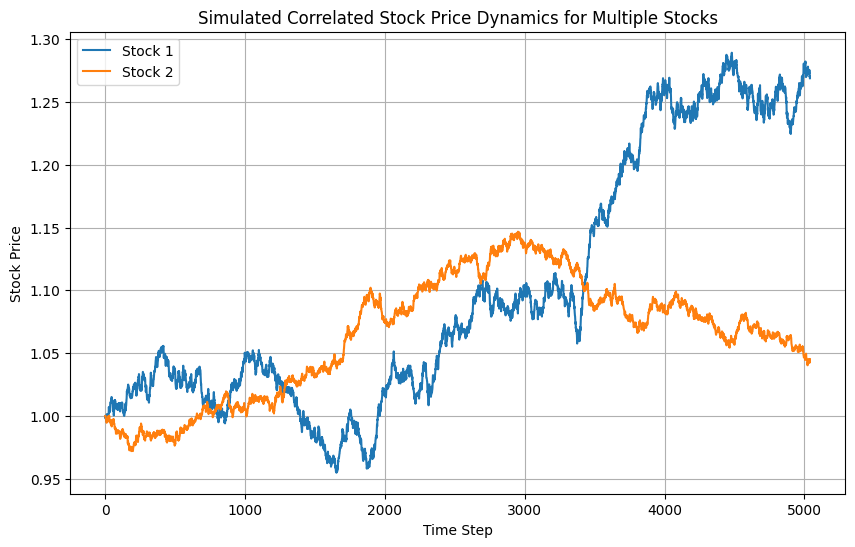

In [66]:
def simulate_correlated_stock_prices(S0, means, correlation_matrix, timesteps=100):
    n = len(S0)
    vector = st.multivariate_normal.rvs(means, correlation_matrix, size=(timesteps, 1)) +1
    #print((vector))
    stock_prices = pd.DataFrame(columns=[f'Stock_{i+1}' for i in range(n)])
    #print(stock_prices)
    for i in range(n):
        prices = np.insert(vector[:, i], 0, S0[i])
        #print(prices)
        prices = np.cumprod(prices)
        #print(prices)
        #print(len(prices))
        stock_prices[f'Stock_{i+1}'] = prices
    return stock_prices

# Example usage with multiple correlated stocks
S0 = [1, 1]  # Initial stock prices for each stock
means = [0.000003, 0.000002]  
correlation_matrix = np.array([[0.0000034, -0.00000075], [-0.00000075, 0.0000012]]) 
timesteps = 5040
stock_prices = simulate_correlated_stock_prices(S0, means, correlation_matrix , timesteps)
# Plotting
plt.figure(figsize=(10, 6))
for i in range(len(stock_prices.columns)):
    plt.plot(stock_prices.index, stock_prices[f'Stock_{i+1}'], label=f'Stock {i+1}')

plt.title('Simulated Correlated Stock Price Dynamics for Multiple Stocks')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


In [35]:
len(st.multivariate_normal.rvs(means, correlation_matrix, size=(timesteps, len(S0))))

5040

In [253]:
int(5>1)

1

In [31]:
stock_prices.tail()

,Stock_1,Stock_2
199996,1.324556,0.876210
199997,1.321461,0.873948
199998,1.322189,0.874867
199999,1.325367,0.875664
200000,1.325523,0.875344


In [18]:
def StandardizeData(data, n):
    if isinstance(data, pd.DataFrame):
        df = data.copy()  # Make a copy to avoid modifying the original DataFrame
    elif isinstance(data, list):
        df = pd.DataFrame(data)  # Convert list to DataFrame
    else:
        raise ValueError("Input data must be a DataFrame or a list.")
    
    Standardized = pd.DataFrame()
    for col in df.columns:
        #print(col)
        ST = pd.DataFrame()
        for i in range(n+1):
            ST[i] = df[col].shift(-i) /df[col].shift(-n)
        Standardized = pd.concat([Standardized, ST], axis=1, ignore_index=True)
        Standardized.dropna()
    Ratio = pd.DataFrame()
    for col in df.columns:
        
        Ratio[col] = df[col].shift(-n-1) /df[col].shift(-n)
        Ratio.dropna()


    return Standardized[:-n-1], Ratio[:-n-1]




In [19]:
InputStates, RewardVector = StandardizeData(stock_prices, 4)
InputStates.head()

,0,1,2,3,4,5,6,7,8,9
0,0.996547,0.997745,1.000070,1.000632,1.0,0.998149,0.997931,1.000122,1.000174,1.0
1,0.997237,0.999561,1.000122,0.999491,1.0,0.995711,0.997897,0.997949,0.997775,1.0
2,1.000988,1.001550,1.000918,1.001428,1.0,1.000578,1.000630,1.000456,1.002686,1.0
3,0.998974,0.998343,0.998852,0.997428,1.0,0.995813,0.995639,0.997859,0.995186,1.0
4,0.999929,1.000439,0.999012,1.001589,1.0,0.996530,0.998752,0.996076,1.000895,1.0


In [22]:
###Save Data 
with pd.ExcelWriter('data.xlsx') as writer:
    RewardVector.to_excel(writer, sheet_name='RewardVector', index=False)
    InputStates.to_excel(writer, sheet_name='InputStates', index=False)
    stock_prices.to_excel(writer, sheet_name='df', index=False)

In [29]:

def tangency_weights(covariance_matrix, mean_vector):
    n = len(mean_vector)
    
    # Objective function to maximize (Sharpe ratio)
    def objective_function(weights):
        portfolio_return = np.dot(weights, mean_vector)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
        return -portfolio_return / portfolio_std
    
    # Constraint: sum of weights equals 1
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    
    # Bounds for each weight (0 <= weight <= 1)
    bounds = tuple((0, 1) for _ in range(n))
    
    # Initial guess for weights
    initial_guess = np.ones(n) / n
    
    # Optimization
    result = minimize(objective_function, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    
    # Extracting optimal weights
    optimal_weights = result.x
    
    # Calculate the mean and standard deviation of the tangency portfolio
    tangency_return = np.dot(optimal_weights, mean_vector)
    tangency_std = np.sqrt(np.dot(optimal_weights.T, np.dot(covariance_matrix, optimal_weights)))
    
    return {
        'weights': optimal_weights,
        'mean': tangency_return,
        'std': tangency_std,
        'maximized_value': -result.fun  # Negative because we minimized the negative of Sharpe ratio
    }
result = tangency_weights(covariance_matrix=correlation_matrix, mean_vector=means)
print("Optimal Weights:", result['weights'])
print("Tangency Portfolio Mean:", result['mean'])
print("Tangency Portfolio Standard Deviation:", result['std'])
print("Maximized Value:", result['maximized_value'])


In [30]:
result = tangency_weights(covariance_matrix=correlation_matrix, mean_vector=means)
print("Optimal Weights:", result['weights'])
print("Tangency Portfolio Mean:", result['mean'])
print("Tangency Portfolio Standard Deviation:", result['std'])
print("Maximized Value:", result['maximized_value'])

Optimal Weights: [0.36071516 0.63928484]
Tangency Portfolio Mean: 2.360715160923276e-06
Tangency Portfolio Standard Deviation: 0.0007661037651980595
Maximized Value: 0.003081456152761453


In [8]:
lity = np.array([5,3,2])
np.exp(lity)

array([148.4131591 ,  20.08553692,   7.3890561 ])